<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/notebooks/sensitivity/SensitivityAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Based on the original sensitivity analysis notebook at
# https://github.com/nitrogenlab/GP15_watermassanalysis/blob/5d0420ae4b8a4689a8cee98e36876e8ed2cb8c68/GP15analysis_sensitivityanalysis.ipynb

#Install pyompa
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/


%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1138, done.
remote: Counting objects: 100% (446/446), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 1138 (delta 310), reused 259 (delta 146), pack-reused 692
Receiving objects: 100% (1138/1138), 14.91 MiB | 40.17 MiB/s, done.
Resolving deltas: 100% (796/796), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit a2a3dc30be711b9f84d74f00e844ad1473f05216 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Thu Sep 23 15:18:03 2021 -0500

    bugfix
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discuss

<module 'pyompa' from '/usr/local/lib/python3.7/dist-packages/pyompa/__init__.py'>

In [2]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 79 (delta 39), reused 53 (delta 18), pack-reused 0
Unpacking objects: 100% (79/79), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit bc6117de8554247c338621bc6881f5a4f0edb500 (HEAD -> main, origin/main, origin/HEAD)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Thu Sep 30 13:29:36 2021 -0700

    import fix
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |█

<module 'gp15wma' from '/usr/local/lib/python3.7/dist-packages/gp15wma/__init__.py'>

In [3]:
gp15_df, gp15_intermediateanddeep, gp15_thermocline = gp15wma.download_and_load_gp15_data(
    station_to_tc_cutoffs_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json")

Rows in gp15 datafile: 1125
Rows without NA values: 1122


In [4]:
interanddeep_endmember_df = gp15wma.load_interanddeep_endmember_df(
    df_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_mode_waters_intermediateanddeep_endmemberswithsubtypes.csv",
    df_file_name="GP15_intermediateanddeep.csv")


In [5]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments
import numpy as np
import json

#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = gp15wma.settingdefaults.PARAM_WEIGHTINGS

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

intermediate_and_deep_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": gp15_intermediateanddeep,
          "endmembername_to_usagepenaltyfunc": gp15wma.settingdefaults.USAGE_PENALTY,
          "param_names": gp15wma.settingdefaults.PARAM_NAMES,
          "convertedparam_groups": gp15wma.settingdefaults.CONVERTEDPARAM_GROUPS
          },
        solve_arguments={
            "endmember_df": interanddeep_endmember_df,
            "endmember_name_column": "watermass_name",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = intermediate_and_deep_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":[
         "lat", "lon", "Depth", "stnnbr", "geotrc_ID"]})

On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'conservative_temp': 50.526633616124734, 'absolute_salinity': 67.46596781384733, 'silicate': 3.3314168678086586, 'nitrate': 5.564955985200404, 'phosphate': 5.523207828614988, 'oxygen': 1.1657612453077295, 'NO': 1.063449112776969, 'PO': 0.5136735163145865}}, solve_arguments={})
Adding penalty for ENPCW_0
Adding penalty for ENPCW_1
Adding penalty for SPCW_0
Adding penalty for SPCW_1
Adding penalty for PSUW_0
Adding penalty for PSUW_1
Adding penalty for ESSW_0
Adding penalty for ESSW_1
Adding penalty for EqIW_0
Adding penalty for EqIW_1
Adding penalty for LCDW_0
Adding penalty for LCDW_1
Adding penalty for PDW_0
Adding penalty for PDW_1
Adding penalty for AAIW_0
Adding penalty for AAIW_1
Adding penalty for UCDW_0
Adding penalty for AABW_0
Endmember-idx mapping is
 OrderedDict([('AABW', [0]), ('AAIW', [1, 2]), ('DtW', [3, 4]), ('ENPCW', [5, 6]), ('ESSW', [7, 8]), ('EqIW', [9, 10]), 

In [6]:
from gp15wma.sensitivity import get_mean_and_stdev_skeletons

mean_skeleton, std_skeleton = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

mean


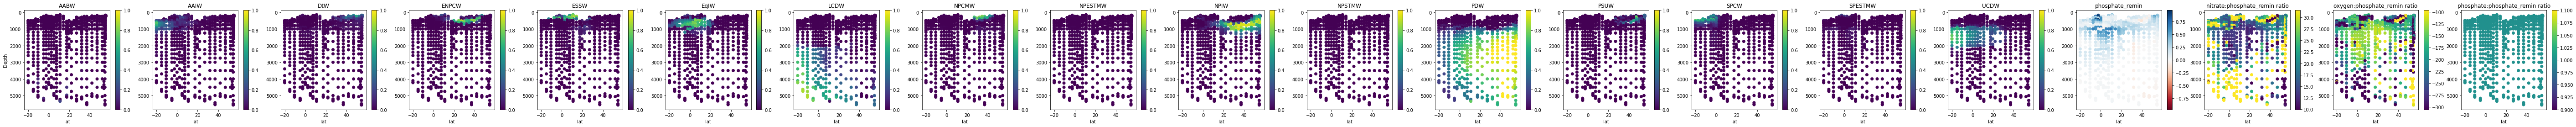

std


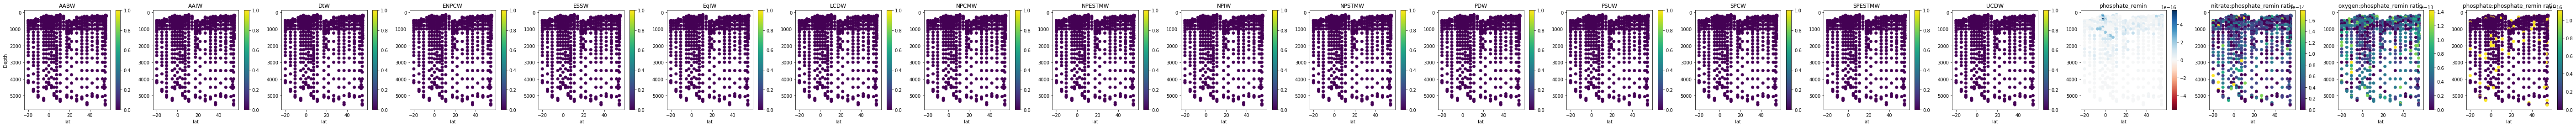

In [7]:
#plot the solutions
print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth",
                                  group_endmembers=True)
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth",
                                  group_endmembers=True)


mean


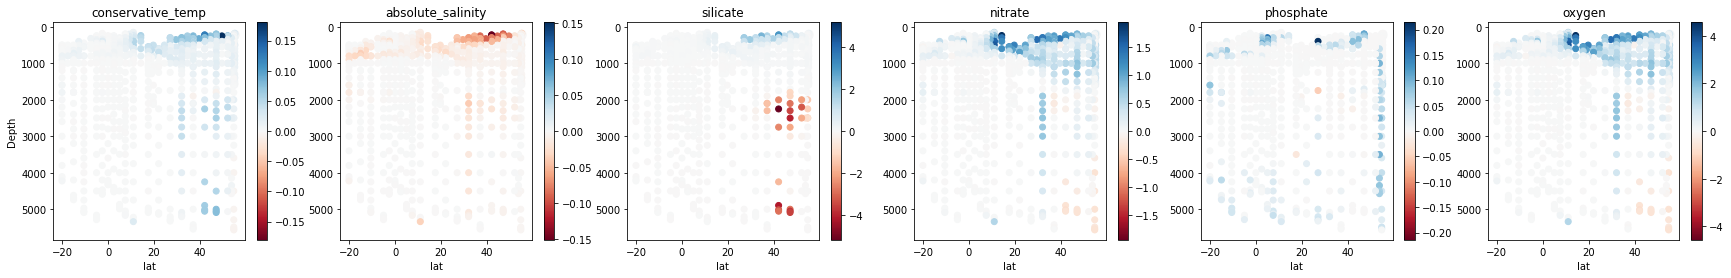

std


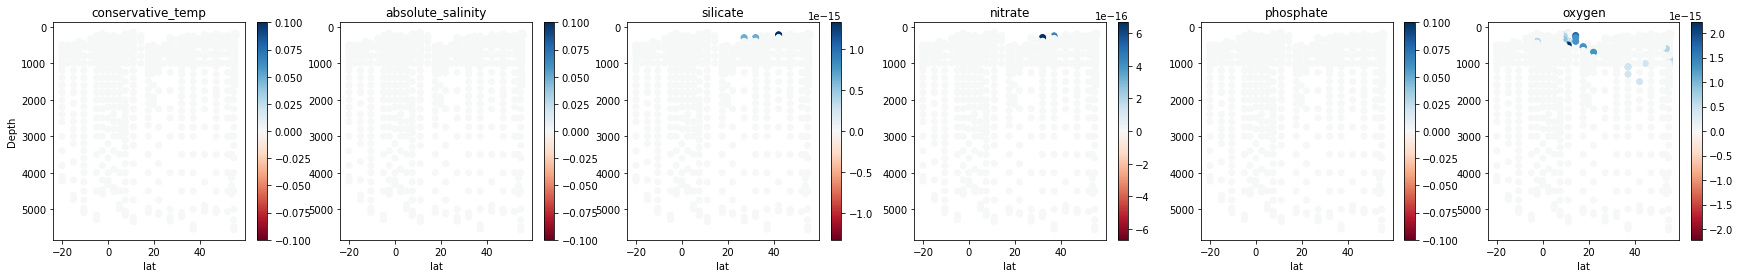

In [8]:
print("mean")
pyompa.plot_ompasoln_residuals(ompa_soln=mean_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")
print("std")
pyompa.plot_ompasoln_residuals(ompa_soln=std_skeleton,
                                  xaxis_colname="lat",
                                  yaxis_colname="Depth")